In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Time Series Data:** Each data point in a time series is linked to a timestamp, which shows the exact time when the data was observed or recorded. Many fields, including finance, economics, weather forecasting, and machine learning, frequently employ this kind of data.

The fact that time series data frequently display patterns or trends across time, such as seasonality or cyclical patterns, is an essential feature associated with it. To make predictions or learn more about the underlying processes or occurrences being observed, these patterns can be analyzed and modeled.

Recurrent Neural Networks (RNN) model the temporal dependencies present in the data as it contains an implicit memory of previous inputs. Hence, time series data being sequential in nature is often used in RNN. For working with time series data in RNNs, TensorFlow provides a number of APIs and tools, like tf.keras.layers.RNN API, which allows to create of unique RNN cell classes and use them with data. Several RNN cell types are also supported by this API, including Basic RNN, LSTM, and GRU. 

#  Import the required libraries.

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math


In [4]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=293376 sha256=f4835b5925bf1f20f276f12ef41e32c743a989bcfeb60d3af9a553a1c844af38
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee


Step 2: This code uses the yf.download() method of the yfinance library to download historical stock data for Google from Yahoo Finance. Using the dt.datetime() method of the datetime module, the start and end dates of the time period for which the data has been obtained are given.

The downloaded data is then shown using the print() function, where the Pandas DataFrame’s display options are configured using pd.set_option().

In [21]:
#the start and end date
start_date = dt.datetime(2020,4,1)
end_date = dt.datetime(2023,4,1)

#loading from yahoo finance
data = yf.download("GOOGL",start_date, end_date)

pd.set_option('display.max_rows', 4)
pd.set_option('display.max_columns',5)
print(data)


[*********************100%%**********************]  1 of 1 completed

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-04-01   56.200001   56.471001  ...   55.105000  51970000
2020-04-02   55.000000   56.138500  ...   55.851501  56410000
...                ...         ...  ...         ...       ...
2023-03-30  100.910004  101.160004  ...  100.889999  33086200
2023-03-31  101.300003  103.889999  ...  103.730003  36863400

[756 rows x 6 columns]


**Step 3:** Next, we split the dataset into training and testing in the ratio 80:20. Only the first column of the data is chosen using iloc[:,:1] and the train_data contains the first training_data_len rows of the original data. The test_data, contains all of the remaining rows of the original data starting from training_data_len to the end.

In [22]:
# Setting 80 percent data for training
training_data_len = math.ceil(len(data) * .8)
training_data_len 

#Splitting the dataset
train_data = data[:training_data_len].iloc[:,:1] 
test_data = data[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)


(605, 1) (151, 1)


**Step 4:** This code creates a numpy array called dataset_train and populates it with the “Open” pricing values from the training data. The 1-dimensional array is then transformed into a 2-dimensional array. The shape property, which returns the tuple (num_rows, num_columns) denoting the dataset_train array’s final shape.

In [23]:
# Selecting Open Price values
dataset_train = train_data.Open.values 
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1)) 
dataset_train.shape


(605, 1)

**Step 5:** Normalization is a crucial step in data preprocessing to enhance the effectiveness and interpretability of machine learning models. Hence MinMaxScaler from sklearn is imported to scale the dataset from 0 to 1. Using the sklearn fit_transform() method, the training dataset is scaled.

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])


[[0.01246754]
 [0.        ]
 [0.00764156]
 [0.01714287]
 [0.0607844 ]]


**Step 6:** The same data preprocessing is done for test data.

In [25]:
# Selecting Open Price values
dataset_test = test_data.Open.values 
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1)) 
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test) 
print(*scaled_test[:5])


[0.98362881] [1.] [0.83867656] [0.84481572] [0.86118691]


**Step 7:** The time-series data must be divided into X_train and y_train from the training set and X_test and y_test from the testing set in this phase. It is done to turn time series data into a supervised learning problem that can be utilized to train the model. The loop generates input/output sequences of length 50 while iterating through the time series data. Using this method, we can forecast future values while taking into consideration the data’s temporal dependence on prior observations.

**For training set:**

In [26]:
X_train = []
y_train = []
for i in range(50, len(scaled_train)):
	X_train.append(scaled_train[i-50:i, 0])
	y_train.append(scaled_train[i, 0])
	if i <= 51:
		print(X_train)
		print(y_train)
		print()


[array([0.01246754, 0.        , 0.00764156, 0.01714287, 0.0607844 ,
       0.05355843, 0.06139221, 0.05272728, 0.0727117 , 0.0761091 ,
       0.08682596, 0.0943896 , 0.08825454, 0.07413508, 0.0733039 ,
       0.08609869, 0.08051948, 0.09974024, 0.09516887, 0.12727273,
       0.12018702, 0.11641037, 0.1081195 , 0.12337662, 0.13402599,
       0.13574544, 0.14640004, 0.14378702, 0.16011432, 0.14345973,
       0.12130912, 0.12896625, 0.13588574, 0.14830132, 0.15021299,
       0.16155324, 0.15787013, 0.17764155, 0.16623377, 0.15584416,
       0.16645714, 0.16919484, 0.17402597, 0.178026  , 0.17495062,
       0.16396881, 0.16949613, 0.17934547, 0.18779741, 0.17715843])]
[0.16927791446834417]

[array([0.01246754, 0.        , 0.00764156, 0.01714287, 0.0607844 ,
       0.05355843, 0.06139221, 0.05272728, 0.0727117 , 0.0761091 ,
       0.08682596, 0.0943896 , 0.08825454, 0.07413508, 0.0733039 ,
       0.08609869, 0.08051948, 0.09974024, 0.09516887, 0.12727273,
       0.12018702, 0.11641037, 0.10

**For testing set:**

In [27]:
X_test = []
y_test = []
for i in range(50, len(scaled_test)):
	X_test.append(scaled_test[i-50:i, 0])
	y_test.append(scaled_test[i, 0])


**Step 8:** In this step, the data is converted into a format that is suitable for input to an RNN. np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) transforms the X_train array, which was originally a 2-dimensional array of shape (samples, features), into a 3-dimensional array of shape (samples, time steps, features), where time steps denotes the number of time steps in the input sequence and features denotes the number of features in the input data. Size 1 is an additional dimension that serves as an indication that each time step only has a single feature.

The y_train array is transformed from a 1-dimensional array of shape (samples) into a 2-dimensional array of shape (samples, 1) by np.reshape(y_train, (y_train.shape[0], 1)), where each row represents the output value at a certain time step. 

**For training set:**

In [28]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)


X_train : (555, 50, 1) y_train : (555, 1)


**For testing set:**

In [29]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)


X_test : (101, 50, 1) y_test : (101, 1)


**Step 9:** Three RNN models are created in this step. The libraries needed for the model is imported.

In [30]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error


**SimpleRNN Model:**
Using the Keras API, this code creates a recurrent neural network (RNN) with four layers of basic RNNs and a dense output layer. It makes use of the tanh hyperbolic tangent activation function. To avoid overfitting, a dropout layer with a rate of 0.2 is introduced. It employs the optimizer as Adam, mean squared error as the loss function, and accuracy as the evaluation metric while compiling. With a batch size of 2, it fits the model to the training data for 20 epochs. The number of parameters in each layer and the overall number of parameters in the model are listed in a summary of the model architecture.

In [31]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50, 
						activation = "tanh",
						return_sequences = True,
						input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50, 
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
								decay=1e-6, 
								momentum=0.9, 
								nesterov=True), 
				loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 2, batch_size = 2)
regressor.summary()


Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


278/278 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0413
Epoch 2/2
278/278 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0069


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 50, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 50, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 50, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,604 (139.08 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,803 (69.55 KB)

**LSTM RNN Model:**  
This code creates a LSTM Model with three layers and a dense output layer. It employs the optimizer as Adam, mean squared error as the loss function, and accuracy as the evaluation metric while compiling. With a batch size of 1, it fits the model to the training data for 10 epochs. The number of parameters in each layer and the overall number of parameters in the model are listed in a summary of the model architecture.

In [32]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50, 
					return_sequences = True, 
					input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50, 
					return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
					loss = 'mean_squared_error',
					metrics = ["accuracy"])

#Fitting the model
regressorLSTM.fit(X_train, 
				y_train, 
				batch_size = 1, 
				epochs = 2)
regressorLSTM.summary()


Epoch 1/2
555/555 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.0023 - loss: 0.0138
Epoch 2/2
555/555 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.0058 - loss: 0.0027


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

**GRU RNN Model:** 
This code defines a recurrent neural network (RNN) model using the GRU (Gated Recurrent Unit) layer in Keras. It consists of four stacked GRU layers followed by a single output layer. It makes use of the ‘tanh’ hyperbolic tangent activation function. To avoid overfitting, a dropout layer with a rate of 0.2 is introduced. It employs the optimizer as Stochastic Gradient Descent (SGD) with a learning rate of 0.01, the decay rate of 1e-7, the momentum of 0.9, and Nesterov is set to False. The mean squared error is the loss function, and accuracy is the evaluation metric while compiling. With a batch size of 2, it fits the model to the training data for 20 epochs. The number of parameters in each layer and the overall number of parameters in the model are listed in a summary of the model architecture.

In [33]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					input_shape=(X_train.shape[1],1),
					activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50, 
					activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
					activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, 
								decay=1e-7, 
								momentum=0.9, 
								nesterov=False),
					loss='mean_squared_error')

# Fitting the data
regressorGRU.fit(X_train,y_train,epochs=2,batch_size=1)
regressorGRU.summary()


Epoch 1/2
555/555 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - loss: 0.1673
Epoch 2/2
555/555 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.0037


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,804 (421.11 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,903 (210.56 KB)

**Step 10:** The X_test data is then used to make predictions from all three models.

In [34]:
# predictions with X_test data
y_RNN = regressor.predict(X_test)
y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step


**Step 11:**  The predicted values are transformed back from the normalized state to their original scale using the inverse_transform() function.

In [36]:
# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN) 
y_LSTM_O = scaler.inverse_transform(y_LSTM) 
y_GRU_O = scaler.inverse_transform(y_GRU)


**Step 12:** Visualize the predicted prices using matplotlib.

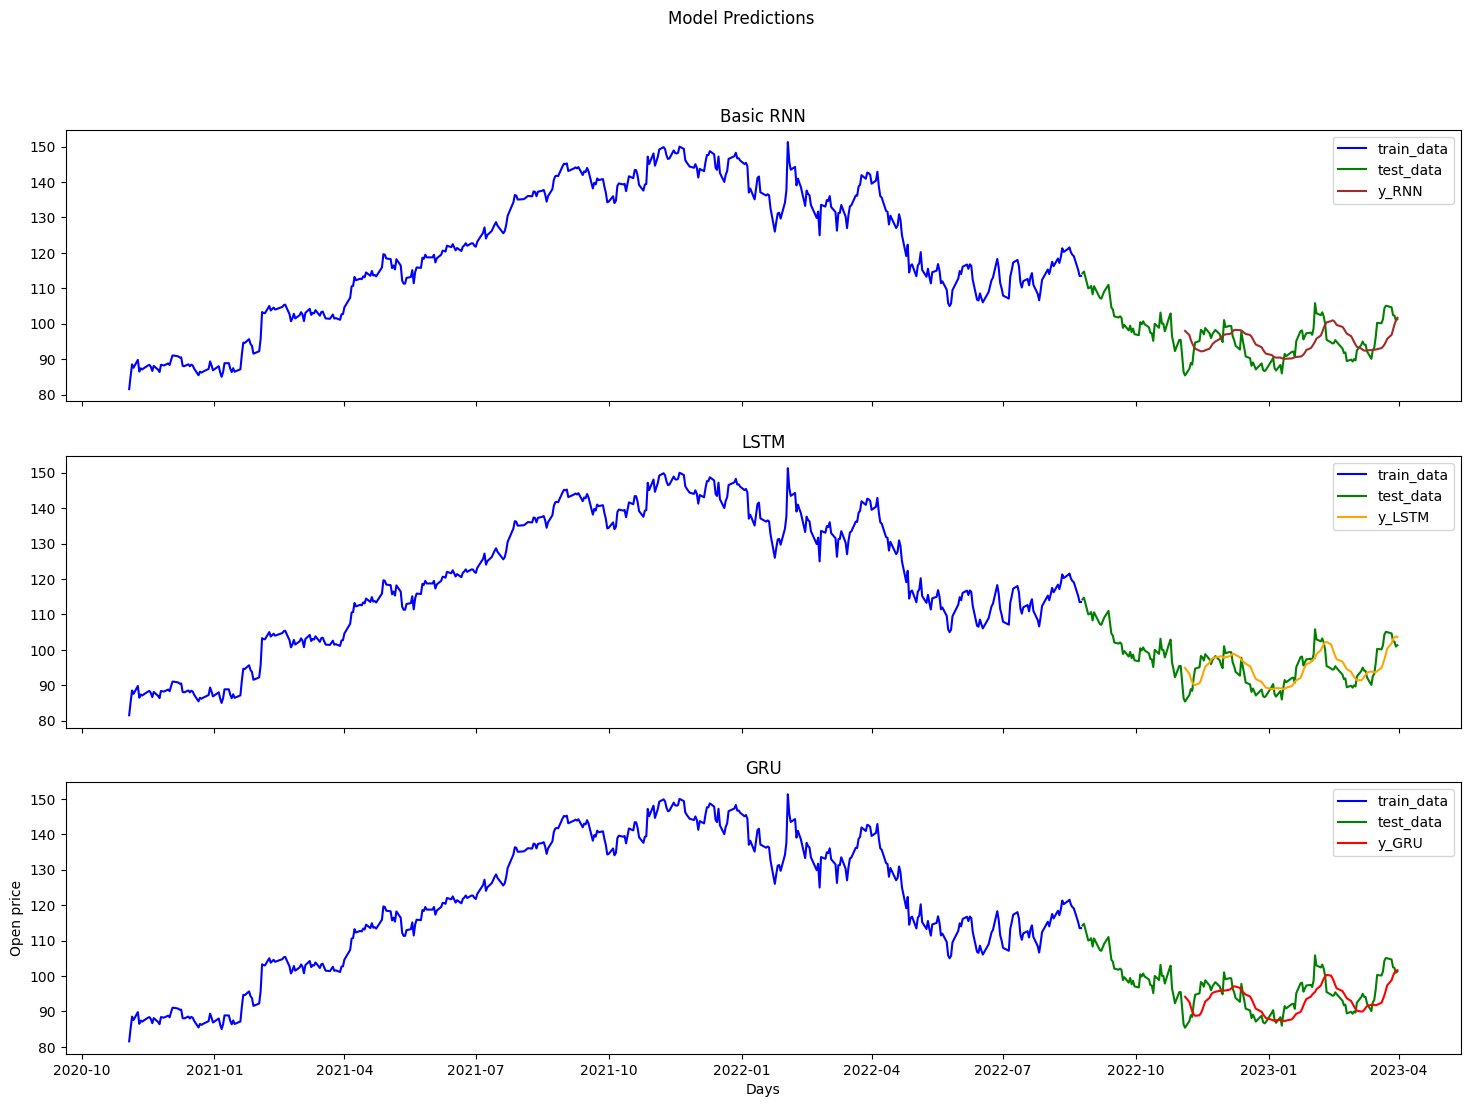

In [37]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[1].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[1].plot(test_data.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

#Plot for GRU predictions
axs[2].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[2].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Open price")

plt.show()
